In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

Using TensorFlow backend.


In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [09:11<00:00,  1.21it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:07<00:00,  8.20it/s]

Done!


In [8]:
# Build Custom U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.3) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)

u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

c6 = Conv2D(1, (1, 1), activation='sigmoid') (c5)

outputs = c6

model = Model(input = inputs, output = outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 16) 448         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 256, 256, 16) 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [10]:
# Define model compile parameters
optimizer = 'adam'
loss      = 'binary_crossentropy'
metrics   = [mean_iou]

# Compile our model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
# Define early stopper to stop at 5 non improving epochs
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-sol-7-cnn-best.h5', verbose=1, save_best_only=True)

# Fit train
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=20, callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 725s 1s/step - loss: 0.3461 - mean_iou: 0.4259 - val_loss: 0.2420 - val_mean_iou: 0.4990

Epoch 00001: val_loss improved from inf to 0.24196, saving model to model-sol-7-cnn-best.h5
Epoch 2/20
603/603 [==============================] - 181s 300ms/step - loss: 0.1806 - mean_iou: 0.5546 - val_loss: 0.1403 - val_mean_iou: 0.5971

Epoch 00002: val_loss improved from 0.24196 to 0.14033, saving model to model-sol-7-cnn-best.h5
Epoch 3/20
603/603 [==============================] - 194s 322ms/step - loss: 0.1617 - mean_iou: 0.6203 - val_loss: 0.1287 - val_mean_iou: 0.6393

Epoch 00003: val_loss improved from 0.14033 to 0.12866, saving model to model-sol-7-cnn-best.h5
Epoch 4/20
603/603 [==============================] - 198s 329ms/step - loss: 0.1386 - mean_iou: 0.6565 - val_loss: 0.1085 - val_mean_iou: 0.6690

Epoch 00004: val_loss improved from 0.12866 to 0.10846, saving model to model-sol-7-cn

KeyboardInterrupt: 

In [12]:
model = load_model('model-sol-7-cnn-best.h5', custom_objects={'mean_iou': mean_iou})

preds_test = model.predict(X_test, verbose=1)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 11s 162ms/step


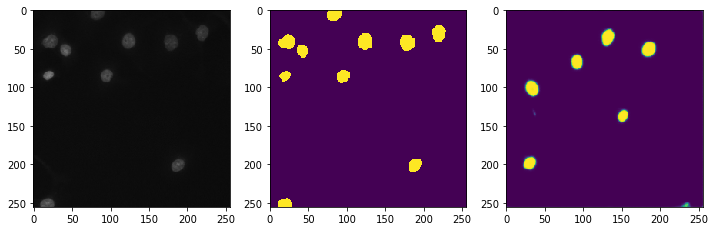

In [13]:
# Display some random training samples
ix = random.randint(0, len(preds_test))

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(X_train[ix])
plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_test[ix]))
plt.show()

In [14]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [15]:
def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sol-7-cnn-sub.csv', index=False)

print sub.shape[0]

2754
